# Preparations

In [2]:
import pandas as pd
import numpy as np

class DateProcessor:    
    """
    Extracts various parts of dates from a pandas Series.
    """
    @staticmethod
    def extract(series, date_parts=["year", "month", "day"]):
        """
        Extract specified date parts from a pandas Series.

        Parameters:
        series (pd.Series): Series object with datetime values.
        date_parts (list): List of date parts to extract.

        Returns:
        pd.DataFrame: DataFrame with extracted date parts as columns.
        """
        parts = []
        colnames = []
        for part in date_parts:
            method_name = f"extract_{part}"
            if hasattr(DateProcessor, method_name):
                extractor = getattr(DateProcessor, method_name)
                parts.append(extractor(series))
                colnames.append(f"{series.name}_{part}")

        return pd.DataFrame(dict(zip(colnames, parts)))

    @staticmethod
    def extract_season(series):
        return series.dt.month.map(DateProcessor.month_number_to_season_name)

    @staticmethod
    def extract_year(series):
        return series.dt.year

    @staticmethod
    def extract_month(series):
        return series.dt.month

    @staticmethod
    def extract_week(series):
        return series.dt.isocalendar().week

    @staticmethod
    def extract_day(series):
        return series.dt.day

    @staticmethod
    def extract_daypart(series):
        return series.dt.hour.map(DateProcessor.hour_number_to_day_part)

    @staticmethod
    def extract_hour(series):
        return series.dt.hour

    @staticmethod
    def extract_weekday(series):
        return series.dt.weekday

    @staticmethod
    def extract_weekend(series):
        return series.dt.weekday.isin([5, 6])

    @staticmethod
    def hour_number_to_day_part(n_hour):
        """
        Convert hour number to part of the day.

        Parameters:
        n_hour (int): Hour of the day.

        Returns:
        str: Part of the day.
        """
        if n_hour < 6 or n_hour >= 22:
            return "midnight"
        elif n_hour < 12:
            return "morning"
        elif n_hour < 18:
            return "afternoon"
        elif n_hour < 22:
            return "evening"
        else:
            return np.nan
    
    @staticmethod
    def month_number_to_season_name(month):
        """
        Convert month number to season name.

        Parameters:
        month (int): Month of the year.

        Returns:
        str: Season name.
        """
        if month in [12, 1, 2]:
            return "Winter"
        elif month in [3, 4, 5]:
            return "Spring"
        elif month in [6, 7, 8]:
            return "Summer"
        elif month in [9, 10, 11]:
            return "Autumn"
        else:
            return np.nan
    
def add_target(df, y):
    """
    Add a target variable to a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to which the target variable will be added.
    y (pd.Series): Target variable.

    Returns:
    pd.DataFrame: DataFrame with target variable.
    """
    return pd.concat([df, y], axis=1)


In [3]:
from sklearn.pipeline import Pipeline

def get_column_names_from_ColumnTransformer(column_transformer):
    """
    Extracts column names from a ColumnTransformer object.

    Parameters:
    column_transformer (ColumnTransformer): The ColumnTransformer object from which to extract column names.

    Returns:
    list: A list of column names.
    """
    col_names = []
    # Iterate over all transformers, excluding the remainder transformer
    for transformer_in_columns in column_transformer.transformers_[:-1]:
        raw_col_names = transformer_in_columns[2]

        # Check if the transformer is a Pipeline and get the last step
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]

        # Attempt to get feature names from the transformer
        try:
            names = transformer.get_feature_names()
        except AttributeError:
            # If the transformer does not have a get_feature_names method, use the raw column names
            names = raw_col_names

        # Add the extracted names to the col_names list
        if isinstance(names, np.ndarray):
            col_names += names.tolist()
        elif isinstance(names, list):
            col_names += names
        elif isinstance(names, str):
            col_names.append(names)

    return col_names

In [4]:
from datetime import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [5]:
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

# Data parsing

In [6]:
import pandas as pd
from datetime import datetime

def read_train_test(train_path, test_path, y_colname, parse_dates=[], date_parser=None):
    """
    Reads training and test datasets from CSV files, extracts the target variable from training data,
    and aligns the columns between the datasets.

    Parameters:
    train_path (str): Path to the training dataset CSV file.
    test_path (str): Path to the test dataset CSV file.
    y_colname (str): Name of the target column in the training dataset.
    parse_dates (list, optional): List of columns to parse as dates.
    date_parser (function, optional): Function to use for parsing dates.

    Returns:
    tuple: A tuple containing the training dataset, target variable, and test dataset.
    """
    try:
        data_train = pd.read_csv(train_path, parse_dates=parse_dates, date_parser=date_parser)
        data_test = pd.read_csv(test_path, parse_dates=parse_dates, date_parser=date_parser)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading files: {e}")

    y = data_train.pop(y_colname)
    common_column_names = set(data_train.columns).intersection(data_test.columns)
    
    return data_train[common_column_names], y, data_test[common_column_names]

# Usage example with a date parser
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
X_train, y, X_submit = read_train_test(
    train_path='train.csv',
    test_path='test.csv',
    y_colname="Outcome",
    parse_dates=['DateTime'],
    date_parser=dateparse
)

/var/folders/m8/cvpvxv7j241g4vlbycyywvk8j1lfvg/T/ipykernel_3029/3698975341.py:48: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data_train[common_column_names], y, data_test[common_column_names]
/var/folders/m8/cvpvxv7j241g4vlbycyywvk8j1lfvg/T/ipykernel_3029/3698975341.py:48: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data_train[common_column_names], y, data_test[common_column_names]


In [7]:
print(len(X_train), len(X_submit))

18710 8019


In [8]:
X_train.head(10)

,AgeuponOutcome,DateTime,AnimalType,Color,Name,Breed,ID,SexuponOutcome
0,2 months,2014-06-11 14:36:00,Cat,Black/White,Socks,Domestic Shorthair Mix,0,Neutered Male
1,1 month,2014-07-18 08:10:00,Cat,Tortie/White,Vera,Domestic Shorthair Mix,1,Intact Female
2,3 months,2016-01-02 17:28:00,Dog,Yellow,Biscuit,Chihuahua Shorthair Mix,2,Neutered Male
3,2 years,2014-02-19 17:27:00,Cat,Calico,Kitten,Domestic Shorthair Mix,3,Spayed Female
4,2 months,2014-07-21 17:34:00,Cat,Orange Tabby,NaN,Domestic Shorthair Mix,4,Neutered Male
5,1 month,2015-07-24 16:50:00,Dog,Black/Tan,London,Rottweiler Mix,5,Spayed Female
6,4 months,2014-11-09 18:15:00,Dog,Buff,Dixie,Chihuahua Shorthair Mix,6,Spayed Female
7,2 years,2015-06-28 16:44:00,Dog,Brown/White,NaN,Chihuahua Shorthair Mix,7,Neutered Male
8,3 years,2014-09-22 12:45:00,Dog,Brown Brindle/White,Ruby,English Coonhound/Italian Greyhound,8,Spayed Female
9,2 years,2015-09-18 15:27:00,Cat,White/Black,Magnum,Domestic Shorthair Mix,9,Neutered Male


In [9]:
print("Train")
print(X_train.isna().mean(axis=0))
    
print('---------')
    
print("Test")
print(X_submit.isna().mean(axis=0))

Train
AgeuponOutcome    0.000748
DateTime          0.000000
AnimalType        0.000000
Color             0.000000
Name              0.289952
Breed             0.000000
ID                0.000000
SexuponOutcome    0.000053
dtype: float64
---------
Test
AgeuponOutcome    0.000499
DateTime          0.000000
AnimalType        0.000000
Color             0.000000
Name              0.282579
Breed             0.000000
ID                0.000000
SexuponOutcome    0.000000
dtype: float64


In [10]:
y.value_counts()

0    7538
1    6595
2    3350
3    1089
4     138
Name: Outcome, dtype: int64

# Work with features

In [11]:
def bread_outcome_features(df):
    return pd.DataFrame({
        "MixOfBreeds": df["Breed"].str.contains("/") | df["Breed"].str.contains("Mix")
    })

bread_outcome_features(X_train.head())

,MixOfBreeds
0,True
1,True
2,True
3,True
4,True


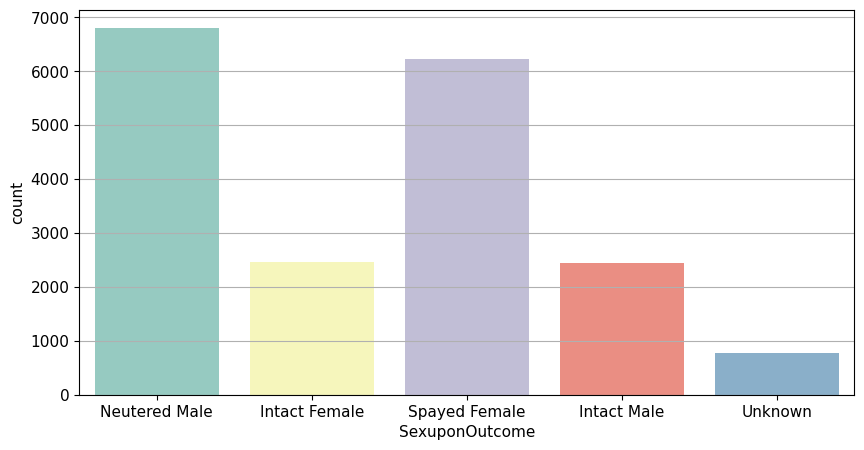

In [12]:
plt.figure(figsize=(10, 5))
_ = sns.countplot(data=X_train, x="SexuponOutcome", palette='Set3')

In [13]:
def seupon_outcome_features(df):
    return pd.DataFrame({
        "IsMale": df["SexuponOutcome"].str.contains("Male"),
        "IsIntact": df["SexuponOutcome"].str.contains("Intact"),
        "IsUnknown":  df["SexuponOutcome"].str.contains("Unknown")
    })

seupon_outcome_features(X_train.head())

,IsMale,IsIntact,IsUnknown
0,True,False,False
1,False,True,False
2,True,False,False
3,False,False,False
4,True,False,False


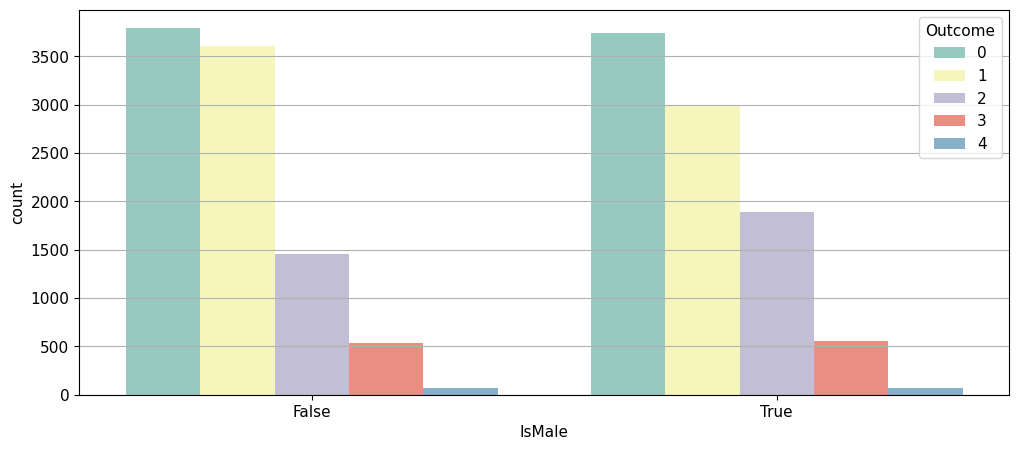

In [14]:
plt.figure(figsize=(12, 5))
_ = sns.countplot(
    data=add_target(seupon_outcome_features(X_train), y), 
    x="IsMale", 
    hue="Outcome",
    palette='Set3'
)

In [15]:
def animal_type_feature(df):
    return pd.DataFrame({
        "IsDog": df["AnimalType"].str.contains("Dog")
    })

animal_type_feature(X_train.head())

,IsDog
0,False
1,False
2,True
3,False
4,False


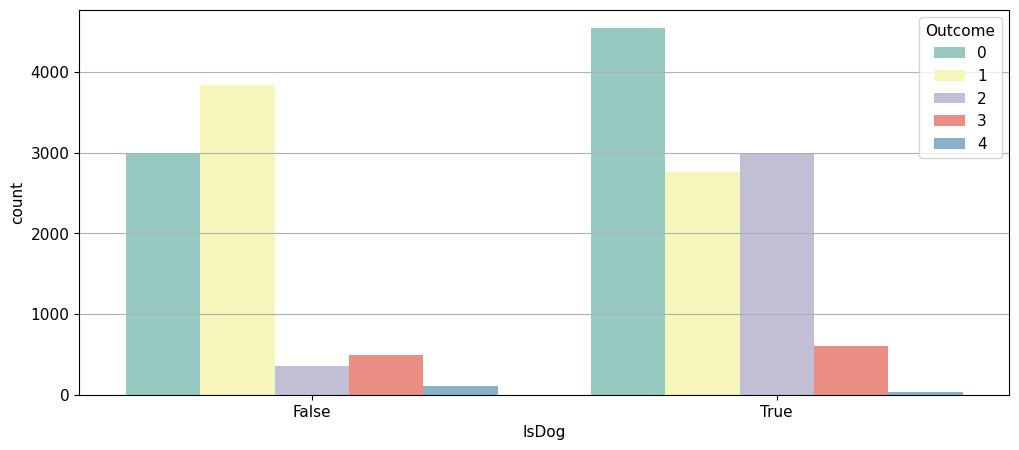

In [16]:
plt.figure(figsize=(12, 5))
_ = sns.countplot(
    data=add_target(animal_type_feature(X_train), y), 
    x="IsDog", 
    hue="Outcome",
    palette='Set3'
)

In [17]:
def animal_type_feature(df):
    return pd.DataFrame({
        "IsDog": df["AnimalType"].str.contains("Dog")
    })

animal_type_feature(X_train.head())

,IsDog
0,False
1,False
2,True
3,False
4,False


In [18]:
def name_feature(df):
    return pd.DataFrame({
        "NameLen": df["Name"].str.len()
    })

name_feature(X_train).value_counts()

NameLen
5.0        3909
6.0        2960
4.0        2620
7.0        1533
8.0         729
3.0         664
9.0         357
10.0        212
11.0        138
12.0         87
2.0          55
1.0          21
dtype: int64

## Date

In [19]:
def datetime_features(df):
    return DateProcessor.extract(df["DateTime"], 
                                     ["year", "season", "weekday", "weekend", 
                                      "hour", "week", "month"])

datetime_features(X_train.head())

,DateTime_year,DateTime_season,DateTime_weekday,DateTime_weekend,DateTime_hour,DateTime_week,DateTime_month
0,2014,Summer,2,False,14,24,6
1,2014,Summer,4,False,8,29,7
2,2016,Winter,5,True,17,53,1
3,2014,Winter,2,False,17,8,2
4,2014,Summer,0,False,17,30,7


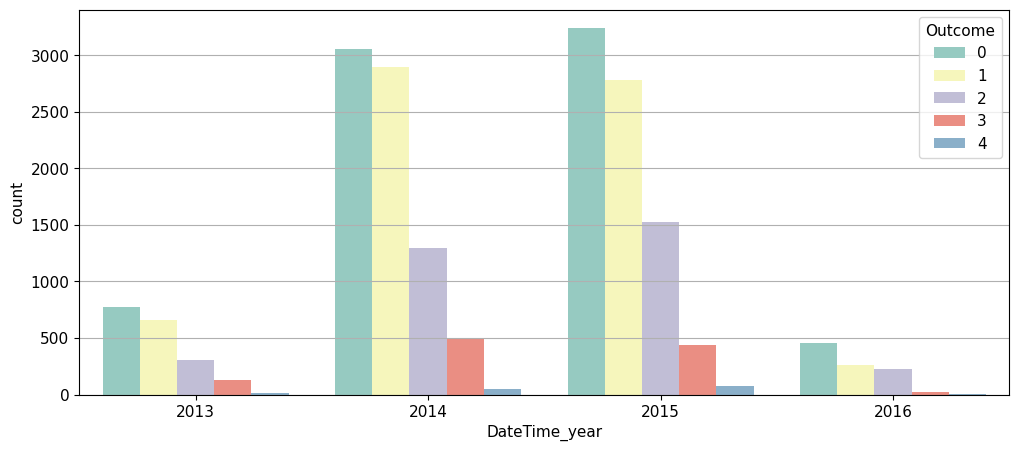

In [20]:
plt.figure(figsize=(12, 5))
_ = sns.countplot(
    data=add_target(datetime_features(X_train), y), 
    x="DateTime_year", 
    hue="Outcome",
    palette='Set3'
)

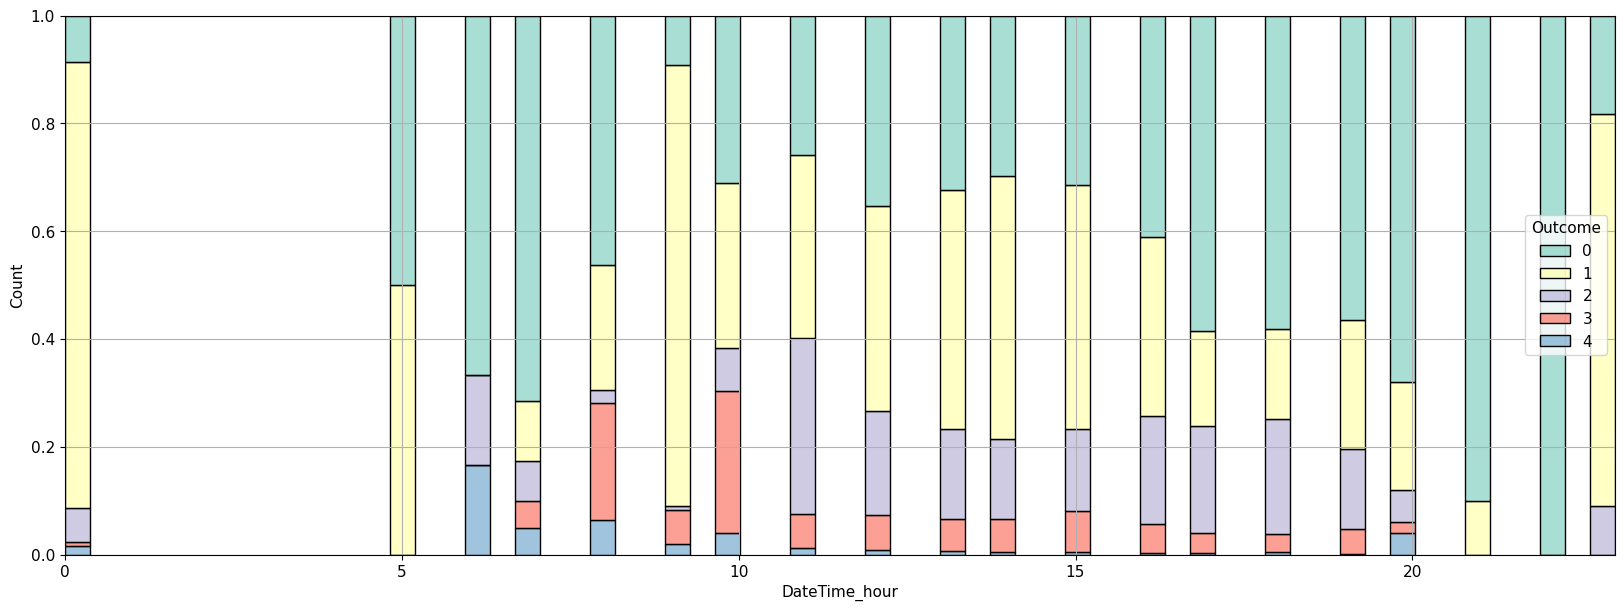

In [21]:
plt.figure(figsize=(20, 7))
_ = sns.histplot(
    data=add_target(datetime_features(X_train), y), 
    x="DateTime_hour", 
    hue="Outcome",
    palette='Set3',
    multiple="fill"
)

## Age upon outcome

In [22]:
def string_to_day(x):   
    try:
        value, duration = x.split()
        value = int(value)
    except:
        return np.nan
    
    if "year" in duration:
        return  value
    elif "month" in duration:
        return value / 12
    elif "week" in duration:
        return value / 52.14
    elif "day" in duration:
        return value / 365.25
    else:
        return np.nan
    
    
def ageupon_outcome_feature(df):
    return pd.DataFrame({
        "AgeuponOutcome_years" : df["AgeuponOutcome"].map(string_to_day)
    })

ageupon_outcome_feature(X_train.head())

,AgeuponOutcome_years
0,0.166667
1,0.083333
2,0.250000
3,2.000000
4,0.166667


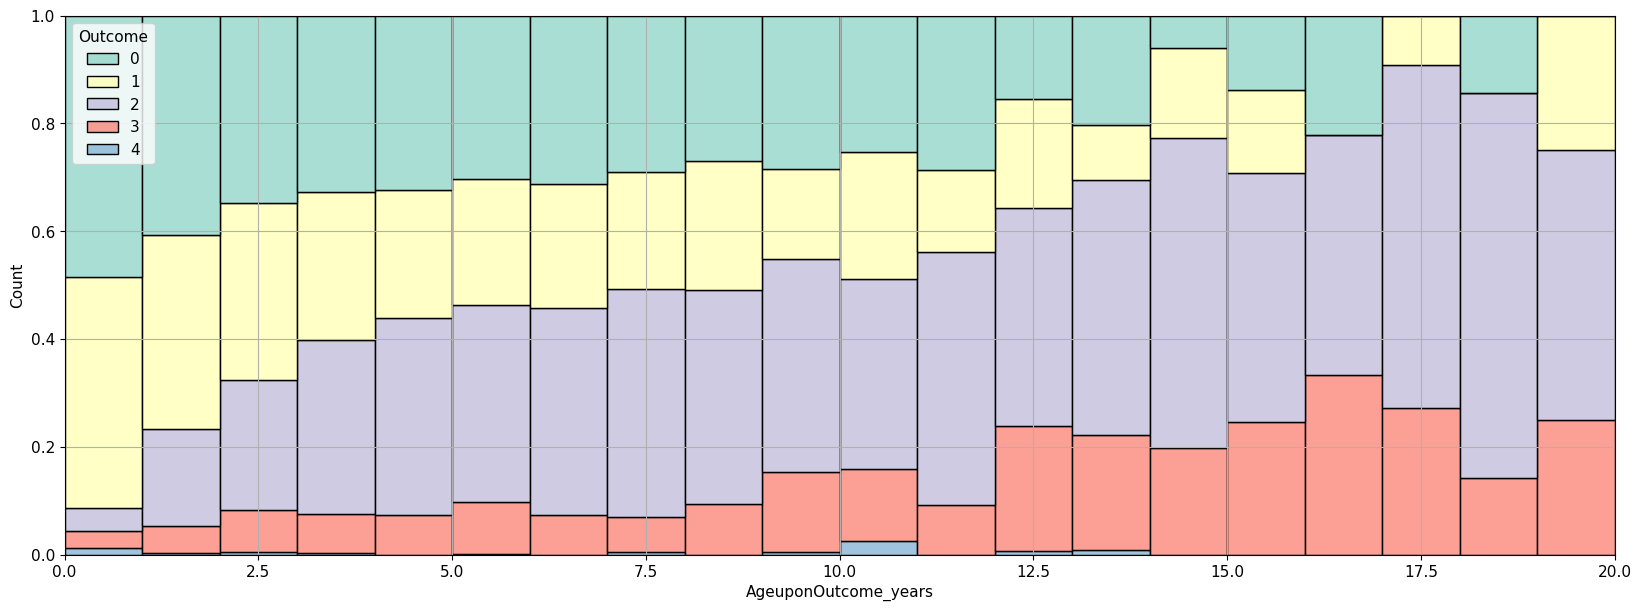

In [23]:
t = ageupon_outcome_feature(X_train)
t[t.AgeuponOutcome_years < 1] = 0

plt.figure(figsize=(20, 7))
_ = sns.histplot(
    data=add_target(t, y), 
    x="AgeuponOutcome_years", 
    hue="Outcome",
    palette='Set3',
    multiple="fill",
    binwidth=1
)

In [24]:
def transform_df(df):
    """
    Applies a series of transformation functions to a DataFrame and concatenates the results.

    Parameters:
    df (pd.DataFrame): The DataFrame to be transformed.

    Returns:
    pd.DataFrame: A DataFrame with the results of all transformations.
    """
    # List of transformer functions to apply to the DataFrame
    transformers = [
        seupon_outcome_features,
        animal_type_feature,
        name_feature,
        datetime_features,
        ageupon_outcome_feature,
        bread_outcome_features
    ]

    transformed_dfs = []
    for transformer in transformers:
        try:
            transformed_dfs.append(transformer(df))
        except Exception as e:
            print(f"Error in transformer {transformer.__name__}: {e}")
            continue

    return pd.concat(transformed_dfs, axis=1)


In [25]:
train = transform_df(X_train)
train.head()

,IsMale,IsIntact,IsUnknown,IsDog,NameLen,DateTime_year,DateTime_season,DateTime_weekday,DateTime_weekend,DateTime_hour,DateTime_week,DateTime_month,AgeuponOutcome_years,MixOfBreeds
0,True,False,False,False,5.0,2014,Summer,2,False,14,24,6,0.166667,True
1,False,True,False,False,4.0,2014,Summer,4,False,8,29,7,0.083333,True
2,True,False,False,True,7.0,2016,Winter,5,True,17,53,1,0.250000,True
3,False,False,False,False,6.0,2014,Winter,2,False,17,8,2,2.000000,True
4,True,False,False,False,NaN,2014,Summer,0,False,17,30,7,0.166667,True


In [26]:
submit = transform_df(X_submit)
submit.head()

,IsMale,IsIntact,IsUnknown,IsDog,NameLen,DateTime_year,DateTime_season,DateTime_weekday,DateTime_weekend,DateTime_hour,DateTime_week,DateTime_month,AgeuponOutcome_years,MixOfBreeds
0,False,True,False,False,NaN,2015,Summer,4,False,15,34,8,0.057537,True
1,False,False,False,False,6.0,2014,Summer,1,False,15,33,8,0.250000,True
2,True,False,False,False,NaN,2014,Winter,6,True,19,51,12,0.166667,True
3,True,False,False,False,6.0,2014,Autumn,4,False,13,46,11,0.333333,True
4,False,False,False,False,7.0,2014,Summer,1,False,15,23,6,0.166667,True


# Filling missed values

In [27]:
train.isna().mean()

IsMale                  0.000053
IsIntact                0.000053
IsUnknown               0.000053
IsDog                   0.000000
NameLen                 0.289952
DateTime_year           0.000000
DateTime_season         0.000000
DateTime_weekday        0.000000
DateTime_weekend        0.000000
DateTime_hour           0.000000
DateTime_week           0.000000
DateTime_month          0.000000
AgeuponOutcome_years    0.000748
MixOfBreeds             0.000000
dtype: float64

In [28]:
submit.isna().mean()

IsMale                  0.000000
IsIntact                0.000000
IsUnknown               0.000000
IsDog                   0.000000
NameLen                 0.282579
DateTime_year           0.000000
DateTime_season         0.000000
DateTime_weekday        0.000000
DateTime_weekend        0.000000
DateTime_hour           0.000000
DateTime_week           0.000000
DateTime_month          0.000000
AgeuponOutcome_years    0.000499
MixOfBreeds             0.000000
dtype: float64

In [29]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted, NotFittedError

def to_float(x):
    return pd.DataFrame(x).astype('float32')

def to_bool(x):
    return pd.DataFrame(x).astype(bool)

# Define the column transformer
bool_imputter_cols = ["IsMale", "IsIntact", "IsUnknown"] 
bool_imputter = Pipeline([
    ("change_type", FunctionTransformer(to_float)),
    ("bool_freq_imputter", SimpleImputer(strategy="most_frequent")),
    ("change_type2", FunctionTransformer(to_bool))
])

preprocessor = ColumnTransformer([
    ('bool', bool_imputter, bool_imputter_cols),
    ('numeric', SimpleImputer(), ["AgeuponOutcome_years"]),
    ('name', SimpleImputer(strategy="constant", fill_value=0), ["NameLen"]),
], remainder="passthrough")

# Function to get column names from ColumnTransformer
def get_column_names_from_ColumnTransformer(column_transformer):
    """
    Extracts column names from a ColumnTransformer object.
    """
    col_names = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:
        raw_col_names = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]

        try:
            names = transformer.get_feature_names_out()
        except AttributeError:
            names = raw_col_names

        if isinstance(names, np.ndarray):
            col_names += names.tolist()
        elif isinstance(names, list):
            col_names += names
        elif isinstance(names, str):
            col_names.append(names)

    return col_names

# Function to create DataFrame from ColumnTransformer
def create_df_from_column_transformer(df, preprocessor):
    """
    Applies a ColumnTransformer to a DataFrame and returns a new DataFrame with transformed data.
    """
    try:
        data = preprocessor.transform(df)
    except NotFittedError:
        data = preprocessor.fit_transform(df)

    transformed_col_names = get_column_names_from_ColumnTransformer(preprocessor)
    remaining_col_names = [col for col in df.columns if col not in transformed_col_names]
    colnames = transformed_col_names + remaining_col_names

    return pd.DataFrame(data, columns=colnames)

In [30]:
X = create_df_from_column_transformer(train, preprocessor)
X.head()

,IsMale,IsIntact,IsUnknown,AgeuponOutcome_years,NameLen,IsDog,DateTime_year,DateTime_season,DateTime_weekday,DateTime_weekend,DateTime_hour,DateTime_week,DateTime_month,MixOfBreeds
0,True,False,False,0.166667,5.0,False,2014,Summer,2,False,14,24,6,True
1,False,True,False,0.083333,4.0,False,2014,Summer,4,False,8,29,7,True
2,True,False,False,0.25,7.0,True,2016,Winter,5,True,17,53,1,True
3,False,False,False,2.0,6.0,False,2014,Winter,2,False,17,8,2,True
4,True,False,False,0.166667,0.0,False,2014,Summer,0,False,17,30,7,True


In [31]:
X.isna().sum()

IsMale                  0
IsIntact                0
IsUnknown               0
AgeuponOutcome_years    0
NameLen                 0
IsDog                   0
DateTime_year           0
DateTime_season         0
DateTime_weekday        0
DateTime_weekend        0
DateTime_hour           0
DateTime_week           0
DateTime_month          0
MixOfBreeds             0
dtype: int64

In [32]:
X_submit = create_df_from_column_transformer(submit, preprocessor)
X_submit.head()

,IsMale,IsIntact,IsUnknown,AgeuponOutcome_years,NameLen,IsDog,DateTime_year,DateTime_season,DateTime_weekday,DateTime_weekend,DateTime_hour,DateTime_week,DateTime_month,MixOfBreeds
0,False,True,False,0.057537,0.0,False,2015,Summer,4,False,15,34,8,True
1,False,False,False,0.25,6.0,False,2014,Summer,1,False,15,33,8,True
2,True,False,False,0.166667,0.0,False,2014,Winter,6,True,19,51,12,True
3,True,False,False,0.333333,6.0,False,2014,Autumn,4,False,13,46,11,True
4,False,False,False,0.166667,7.0,False,2014,Summer,1,False,15,23,6,True


In [33]:
X_submit.isna().sum()

IsMale                  0
IsIntact                0
IsUnknown               0
AgeuponOutcome_years    0
NameLen                 0
IsDog                   0
DateTime_year           0
DateTime_season         0
DateTime_weekday        0
DateTime_weekend        0
DateTime_hour           0
DateTime_week           0
DateTime_month          0
MixOfBreeds             0
dtype: int64

# Creating the model
## Selecting parameters

In [34]:
selected_features = [
    "IsIntact", "IsUnknown", "IsDog", "NameLen", 
    "AgeuponOutcome_years", 
    "DateTime_year", "DateTime_hour", "DateTime_week", 
    "DateTime_weekend",  "DateTime_weekday"
]

In [35]:
y

0        0
1        3
2        2
3        0
4        0
        ..
18705    1
18706    2
18707    0
18708    1
18709    0
Name: Outcome, Length: 18710, dtype: int64

## Here we check the accuracy of the GradientBoostingClassifier
It could provide us with best results, but later we found out that RandomForestClassifier works better.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_val, y_train, y_val = train_test_split(
    X[selected_features],
    y,
    stratify=y,
    test_size=0.25
)

model = GradientBoostingClassifier().fit(X_train, y_train)

y_pred = model.predict(X_val)
print("F1 score:", f1_score(y_val, y_pred, average='weighted'))

F1 score: 0.658117198731933


## RandomForestClassifier + GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val = train_test_split(
    X[selected_features],
    y,
    stratify=y,
    test_size=0.25
)

# Определяем параметры для поиска
param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев в лесу
    'max_depth': [10, 20, None],       # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],   # Минимальное количество образцов, необходимое для разделения узла
    'min_samples_leaf': [1, 2, 4],     # Минимальное количество образцов, требуемое на листе узла
    'bootstrap': [True, False]         # Метод выборки для построения деревьев
}

# Создаём модель RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')

# Обучаем GridSearchCV
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры и соответствующий F1 score
print("Best parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.0s

/Users/shklyarmike/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, mi

In [38]:
# Используем лучший набор параметров для создания новой модели
best_rf_model = grid_search.best_estimator_

# Обучаем лучшую модель на полном обучающем наборе
best_rf_model.fit(X_train, y_train)

# Предсказываем на валидационных данных
y_val_pred = best_rf_model.predict(X_val)

# Оцениваем модель на валидационном наборе данных
f1_val_score = f1_score(y_val, y_val_pred, average='weighted')
print(f"F1 Score on validation data: {f1_val_score}")

F1 Score on validation data: 0.6637627528507072


## RandomForestClassifier + LogisticRegression average (additional)

In [39]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score

# # Обучаем модель RandomForestClassifier
# rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
# rf.fit(X_train, y_train)

# # Обучаем модель LogisticRegression
# # Важно масштабировать данные для логистической регрессии
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

# lr = LogisticRegression(max_iter=1000, random_state=42)
# lr.fit(X_train_scaled, y_train)

# # Получаем предсказания вероятностей для валидационного набора данных
# rf_probs = rf.predict_proba(X_val)
# lr_probs = lr.predict_proba(X_val_scaled)

# # Усредняем предсказанные вероятности
# average_probs = (rf_probs + lr_probs) / 2

# # Превращаем усредненные вероятности обратно в метки классов
# average_preds = np.argmax(average_probs, axis=1)

# # Оцениваем модель на валидационном наборе данных с усредненными вероятностями
# f1_val_score = f1_score(y_val, average_preds, average='weighted')
# print(f"F1 Score on validation data (Random Forest + Logistic Regression): {f1_val_score}")

-----------------------

## Here we'll check the importance of the parameters

In [40]:
pd.Series(best_rf_model.feature_importances_, index=X_train.columns). \
    sort_values(ascending=False)

AgeuponOutcome_years    0.226825
DateTime_week           0.160163
DateTime_hour           0.152205
IsIntact                0.138279
NameLen                 0.129973
DateTime_weekday        0.067353
DateTime_year           0.046013
IsDog                   0.036811
IsUnknown               0.030969
DateTime_weekend        0.011408
dtype: float64

## Confusion matrix (Additional)

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

labels = ["Adoption", 
          "Died", 
          "Euthanasia", 
          "Return_to_owner", 
          "Transfer"]
le = LabelEncoder().fit(labels)

cm = confusion_matrix(y_true=y_val,
                      y_pred=y_pred)
pd.DataFrame(cm,
             index=le.inverse_transform(best_rf_model.classes_),
             columns=le.inverse_transform(best_rf_model.classes_))

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
Adoption,889,656,303,34,3
Died,767,555,300,26,1
Euthanasia,417,277,124,19,1
Return_to_owner,128,88,51,5,0
Transfer,19,7,8,0,0


## Saving results

In [42]:
# Берем DataFrame test_data с теми же признаками, что и X_train
X_test = X_submit[selected_features]

# Сначала загружаем исходный тестовый набор данных для получения столбца ID
test_data_original = pd.read_csv('test.csv')

# Теперь делаем предсказания на тестовых данных, используя лучшую модель
y_test_pred = best_rf_model.predict(X_test)

# Создаем DataFrame для предсказаний, используя ID из исходного тестового набора данных
submission = pd.DataFrame({
    'ID': test_data_original['ID'], 
    'Outcome': y_test_pred
})

# Проверяем, что количество строк соответствует требованиям Kaggle (8019)
assert submission.shape[0] == 8019, f"Неверное количество строк: {submission.shape[0]}"

# Сохраняем предсказания в CSV файл для загрузки на Kaggle
submission.to_csv('submission.csv', index=False)

In [43]:
submission.head()

,ID,Outcome
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0
